In [1]:
!pip install PyPDF2

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 232.6/232.6 kB 2.3 MB/s eta 0:00:00


In [2]:
!pip install python-docx

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 244.3/244.3 kB 3.2 MB/s eta 0:00:00


In [3]:
!pip install contractions

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 289.9/289.9 kB 5.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 110.7/110.7 kB 9.9 MB/s eta 0:00:00


In [4]:
!pip install unidecode

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 235.5/235.5 kB 2.8 MB/s eta 0:00:00


In [5]:
import os
import PyPDF2
import pandas as pd
import docx
import re
import nltk
import contractions
import unidecode
import numpy as np
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer, PorterStemmer
from sklearn.feature_extraction.text import TfidfVectorizer
from gensim.models import Word2Vec
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, adjusted_rand_score, silhouette_score
from sklearn.cluster import DBSCAN
from collections import Counter
from sklearn.metrics import silhouette_score
from sklearn.svm import LinearSVC
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
from sklearn.decomposition import TruncatedSVD
import warnings
warnings.filterwarnings('ignore')

In [6]:
#function to store PDF data
def store_pdf_data(file_path):
  pdf_reader = PyPDF2.PdfReader(file)
  content = ""
  for page_number in range(len(pdf_reader.pages)):
    content += pdf_reader.pages[page_number].extract_text()
  return content

In [7]:
#function to store DOCX data
def store_doc_data(file_path):
  doc = docx.Document(file_path)
  content = ""
  for paragraph in doc.paragraphs:
    content += paragraph.text
  return content

In [8]:
# storing all the data extracted from files into a dataframe
path = "/content/Data"
whole_content=[]
for filename in os.listdir(path):
  row_data = {}
  file_path = os.path.join(path, filename)
  row_data["file_name"]=filename
  if filename.endswith(".pdf"):
    with open(file_path, "rb") as file:
      df_content = store_pdf_data(file_path)
    row_data["content"]=df_content
    row_data["file_type"]="PDF"
    row_data["label"]= filename.split('_')[0]
  elif filename.endswith(".txt"):
    with open(file_path, "r") as file:
      df_content = file.read()
    row_data["content"]=df_content
    row_data["file_type"]="TXT"
    row_data["label"]= filename.split('_')[0]
  elif filename.endswith(".docx"):
    df_content = store_doc_data(file_path)
    row_data["content"]=df_content
    row_data["file_type"]="DOCX"
    row_data["label"]= filename.split('_')[0]
  whole_content.append(row_data)

In [9]:
df = pd.DataFrame(whole_content)

Text cleaning

In [10]:
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('punkt')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


True

In [11]:
# function to perform text cleaning
def clean_text(text):

  #removing contractions
  text = contractions.fix(text)

  #making the text to lowercase
  text = text.lower()

  #removing non-alphabetical charecters
  text = re.sub(r'[^a-zA-Z\s]', '', text)

  #decoding the encoded data
  text = unidecode.unidecode(text)

  #performing tokenization
  tokens = nltk.word_tokenize(text)

  #removing stopwords
  stop_words = set(stopwords.words('english'))
  tokens = [word for word in tokens if word not in stop_words]

  #performing lemmatization
  lemmatizer = WordNetLemmatizer()
  tokens = [lemmatizer.lemmatize(word) for word in tokens]

  return tokens

In [12]:
df['cleaned_content'] = df['content'].apply(clean_text)

In [13]:
#encoding the labels to numerical classification
label_encoding = {
    'education': 0,
    'health': 1,
    'entertainment': 2,
}
df['encoding'] = df['label'].map(label_encoding)
X=df['cleaned_content']
y=df['encoding']

In [73]:
X_train,X_test,y_train,y_test = train_test_split(X,y,train_size = 0.8,random_state = 5778)

## Vectorization

In [74]:
vector_size = 100
window = 5
min_count = 3
workers = 4

#considering word2vec model to create word embeddings
model = Word2Vec(sentences=X, vector_size=vector_size, window=window, min_count=min_count, workers=workers)

model.save("word2vec.model")

In [75]:
#function creating sentence vectors using the word embeddings
def sentence_vector(words, model):
    word_vectors = [model.wv[word] for word in words if word in model.wv]
    if not word_vectors:
        return np.zeros(model.vector_size)
    return np.mean(word_vectors, axis=0)

In [76]:
train_sentence_vectors = [sentence_vector(words, model) for words in X_train]

In [77]:
test_sentence_vectors = [sentence_vector(words, model) for words in X_test]

In [78]:
all_sentence_vectors = [sentence_vector(words, model) for words in X]

##Clustering



In [79]:
# Function to extract metadata
def extract_metadata(file_path):
    return {
        'file_name': os.path.splitext(file_path)[0]
    }

In [80]:
# Extract metadata and normalize features
metadata_features = []
for file_path in df['file_name']:
    metadata = extract_metadata(os.path.join(path, file_path))
    metadata_features.append(metadata)

metadata_df = pd.DataFrame(metadata_features)


In [81]:
from sklearn.preprocessing import LabelEncoder

# Encode the file names to numerical values
label_encoder = LabelEncoder()
metadata_df['file_name_encoded'] = label_encoder.fit_transform(metadata_df['file_name'])


In [82]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
metadata_features_scaled = scaler.fit_transform(metadata_df[['file_name_encoded']])


In [83]:
from gensim import corpora
from gensim.models.ldamodel import LdaModel
# Topic modeling using LDA
dictionary = corpora.Dictionary(df['cleaned_content'])
corpus = [dictionary.doc2bow(text) for text in df['cleaned_content']]
lda_model = LdaModel(corpus, num_topics=3, id2word=dictionary, passes=15)

# Extract topic distributions for each document
def get_topic_distribution(text, model, dictionary):
    bow = dictionary.doc2bow(text)
    topic_distribution = model.get_document_topics(bow, minimum_probability=0)
    return [prob for _, prob in topic_distribution]

topic_distributions = [get_topic_distribution(text, lda_model, dictionary) for text in X]


In [84]:
def calculate_combined_similarity(text_vectors, topic_vectors, metadata_vectors, alpha=0.6, beta=0.2):
    from sklearn.metrics.pairwise import cosine_similarity
    text_similarity = cosine_similarity(text_vectors)
    topic_similarity = cosine_similarity(topic_vectors)
    metadata_similarity = cosine_similarity(metadata_vectors)
    combined_similarity = alpha * text_similarity + beta * topic_similarity + (1 - alpha - beta) * metadata_similarity
    return combined_similarity
combined_similarity = calculate_combined_similarity(all_sentence_vectors, topic_distributions, metadata_features_scaled)

In [85]:
combined_similarity[1]

array([0.99995877, 1.00000001, 0.80087645, 0.99992211, 0.99910219,
       0.99991746, 0.40206646, 0.40064441, 0.93567277, 0.80087156,
       0.40030484, 0.80076374, 0.80040778, 0.40059929, 0.99986495,
       0.80079145, 0.59812014, 0.40046387, 0.40052562, 0.80051739,
       0.82414074, 0.40038924, 0.82713796, 0.80061848, 0.54292499,
       0.53874545, 0.40035342, 0.40052878, 0.80045177, 0.40059965,
       0.40043418, 0.40033035, 0.80056138, 0.99994416, 0.41090422,
       0.40029316, 0.99995865, 0.40047817, 0.99990906, 0.80043174,
       0.99993635, 0.40523009, 0.40039747, 0.99994017, 0.80057569,
       0.99995322, 0.40040253, 0.40063171, 0.99977953, 0.80048234,
       0.99996079, 0.40044897, 0.40038483, 0.40086071, 0.40049039,
       0.40042351, 0.40035521, 0.40045642, 0.42807399, 0.98258932])

In [107]:
def cluster_based_on_similarity(similarity_matrix, threshold):
    n = similarity_matrix.shape[0]
    clusters = []
    visited = set()
    for i in range(n):
        if i not in visited:
            cluster = []
            for j in range(n):
                if similarity_matrix[i, j] >= threshold:
                    cluster.append(j)
                    visited.add(j)
            clusters.append(cluster)
    return clusters

clusters = cluster_based_on_similarity(combined_similarity, threshold=0.982)

In [108]:
for cluster_id, cluster in enumerate(clusters):
    print(f'Cluster {cluster_id}:')
    for point in cluster:
        print(f'- {df.iloc[point]["file_name"]}')

Cluster 0:
- health_essay15.docx
- health_essay4.docx
- health_essay9.docx
- entertainment_essay2.txt
- health_essay20.txt
- health_essay8.txt
- health_essay6.txt
- health_essay2.docx
- health_essay5.pdf
- health_essay3.docx
- health_essay11.docx
- health_essay10.pdf
- entertainment_essay20.pdf
- health_essay17.pdf
- entertainment_essay4.txt
Cluster 1:
- entertainment_essay3.txt
- entertainment_essay9.pdf
- entertainment_essay8.docx
- entertainment_essay7.docx
- entertainment_summary10.docx
Cluster 2:
- education_essay4.docx
- education_essay2.docx
- education_essay19.pdf
- education_summary14.pdf
- education_essay10.txt
- education_essay3.docx
- education_essay5.docx
- education_esaay20.pdf
- education_essay16.pdf
- education_essay17.pdf
- entertainment_data16.pdf
- entertainment_essay18.pdf
- education_essay7.docx
- entertainment_essay15.pdf
- education_essay18.pdf
- education_data15.pdf
- education_essay8.txt
- education_data13.txt
- entertainment_essay12.pdf
- education_essay9.txt


In [109]:
from sklearn.metrics import pairwise_distances, silhouette_score
import numpy as np

distances = 1 - combined_similarity  # Convert similarity to distance

np.fill_diagonal(distances, 0)

def silhouette_score_custom(X, labels):
    return silhouette_score(X, labels, metric='precomputed')

labels = np.zeros(combined_similarity.shape[0], dtype=int)
for cluster_id, cluster in enumerate(clusters):
    for point in cluster:
        labels[point] = cluster_id

silhouette = silhouette_score_custom(distances, labels)
print("Silhouette Score:", silhouette)


Silhouette Score: 0.9354005585189588


## Classification
If the labels of the datapoints are given, we perfrom classification as it is supervised machine learning algorithm.

In [110]:
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

clf_log = LogisticRegression()
clf_dt = DecisionTreeClassifier()
clf_rf = RandomForestClassifier()

# A family of models are considered to perform the classification in order to acquire the best performing algorithm.
models = {
    'Logistic Regression': clf_log,
    'Decision Tree' : clf_dt,
    'Random Forest': clf_rf,
}

# model evaluations are perfromed respectively and the results are compared
def evaluate_model(model, X_train, X_test, y_train, y_test):
  model.fit(train_sentence_vectors, y_train)
  y_pred_train = model.predict(train_sentence_vectors)
  y_pred_test = model.predict(test_sentence_vectors)

  metrics = {
      'Test Accuracy': accuracy_score(y_test, y_pred_test),
      'Test Precision': precision_score(y_test, y_pred_test, average='weighted'),
      'Test Recall': recall_score(y_test, y_pred_test, average='weighted'),
      'Test F1 Score': f1_score(y_test, y_pred_test, average='weighted')
    }
  return metrics

In [111]:
results = {}

for model_name, model in models.items():
  metrics = evaluate_model(model, train_sentence_vectors, test_sentence_vectors, y_train, y_test)
  results[model_name] = metrics

results_df = pd.DataFrame(results).T
results_df.columns = ['Accuracy', 'Precision', 'Recall', 'F1 Score']
results_df['Algorithm'] = results_df.index
results_df = results_df.reset_index(drop=True)

print(results_df)

   Accuracy  Precision    Recall  F1 Score            Algorithm
0  0.250000   0.062500  0.250000  0.100000  Logistic Regression
1  0.750000   0.805556  0.750000  0.725000        Decision Tree
2  0.833333   0.888889  0.833333  0.837037        Random Forest


In [112]:
results_df

,Accuracy,Precision,Recall,F1 Score,Algorithm
0,0.250000,0.062500,0.250000,0.100000,Logistic Regression
1,0.750000,0.805556,0.750000,0.725000,Decision Tree
2,0.833333,0.888889,0.833333,0.837037,Random Forest


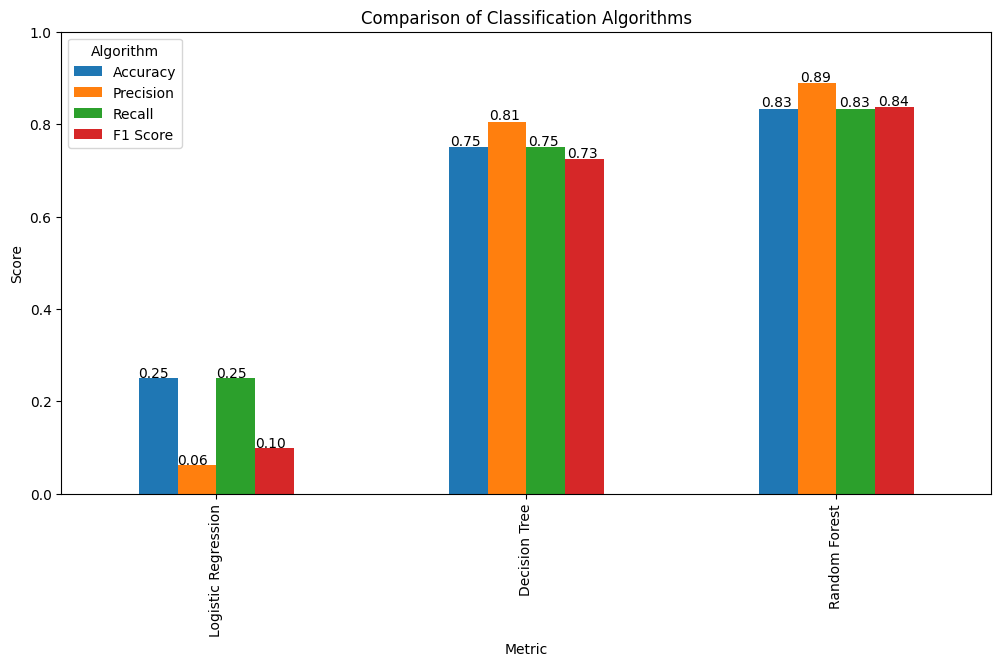

In [113]:
results_df.set_index('Algorithm', inplace=True)

ax = results_df.plot(kind='bar', figsize=(12, 6))

for p in ax.patches:
    ax.annotate(f'{p.get_height():.2f}', (p.get_x() * 1.005, p.get_height() * 1.005))

plt.title('Comparison of Classification Algorithms')
plt.ylabel('Score')
plt.xlabel('Metric')
plt.ylim(0, 1)
plt.legend(title='Algorithm')
plt.show()

#Therefore, we can say that Random Forest classifier works best among all of them.